# Fundamental Particle Physics Detection

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.regularizers import l1
from keras.regularizers import l2
from keras.layers import Dropout

## Data Exploration

In [2]:
df_x = pd.read_csv('./data/xtrain.txt', delim_whitespace=True, header= None)
df_x_test = pd.read_csv('./data/xtest.txt', delim_whitespace=True, header= None)
df_y = pd.read_csv('./data/ytrain.txt', delim_whitespace=True, header= None)

In [3]:
df_x.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.687736,0.000000,1.629054,0.133624,0.697046,0.469575,0.798461,2.173076,1.183318,0.000000,...,0.950595,0.776109,0.963459,-0.662193,0.664283,0.637991,0.255484,1.123420,2.548224,-0.680675
1,0.964365,3.101961,0.714991,0.844022,0.628963,0.399977,-0.686261,0.000000,1.659589,0.000000,...,1.384316,0.924660,1.043015,-0.954050,0.678664,0.635293,-0.172164,0.201338,0.000000,0.145599
2,1.432431,0.000000,0.287587,1.535265,0.773854,0.913009,-0.924088,0.000000,-0.510414,2.214872,...,-0.140638,1.696855,1.554600,-1.502808,1.275629,1.006156,0.207804,-0.915537,2.548224,0.148555
3,0.733932,3.101961,-0.542938,-0.817460,1.613311,2.182126,-0.879184,0.000000,-0.840589,2.214872,...,0.525787,0.791973,2.042827,0.257872,1.243157,1.170578,0.673317,-0.902794,0.000000,0.997448
4,0.953323,0.000000,0.809215,0.410954,2.206056,0.641506,-1.408612,1.086538,-0.043883,0.000000,...,1.380355,0.844227,2.402324,0.175198,1.668432,1.333401,-0.719758,0.494438,1.274112,0.308283


In [4]:
df_y.columns = ['Label']
df_y.Label = df_y.Label.astype(np.int8)
df_y.head()

,Label
0,0
1,0
2,1
3,0
4,0


In [5]:
print(" The number of data available to train is:",df_x.shape[0],'. Each example contains', df_x.shape[1],'features.')
df_y = df_y.values
df_y = df_y[:,0]
print(df_y.shape)

 The number of data available to train is: 11000 . Each example contains 30 features.
(11000,)


In [6]:
print("Number of classes are ",np.size(np.unique(df_y)), ". They are ",np.unique(df_y))


Number of classes are  2 . They are  [0 1]


([<matplotlib.axis.XTick at 0x2b4924ca0f0>,
 <a list of 2 Text xticklabel objects>)

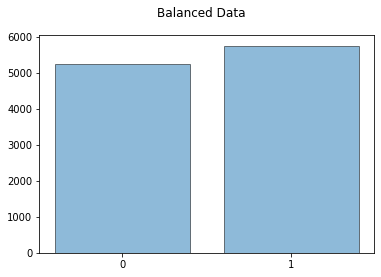

In [7]:
plt.hist( df_y,bins=[-.5,.5,1.5], alpha=0.5, histtype='bar', rwidth=0.8, ec='black')
plt.suptitle('Balanced Data')
plt.xticks((0,1))

In [8]:
print('Mean of means by feature', np.mean(df_x.mean()))
print('Desviation standart of medians',np.std(df_x.mean(axis=0)))

Mean of means by feature 0.5963497176560913
Desviation standart of medians 0.4769325961854292


Text(0, 0.5, 'Values')

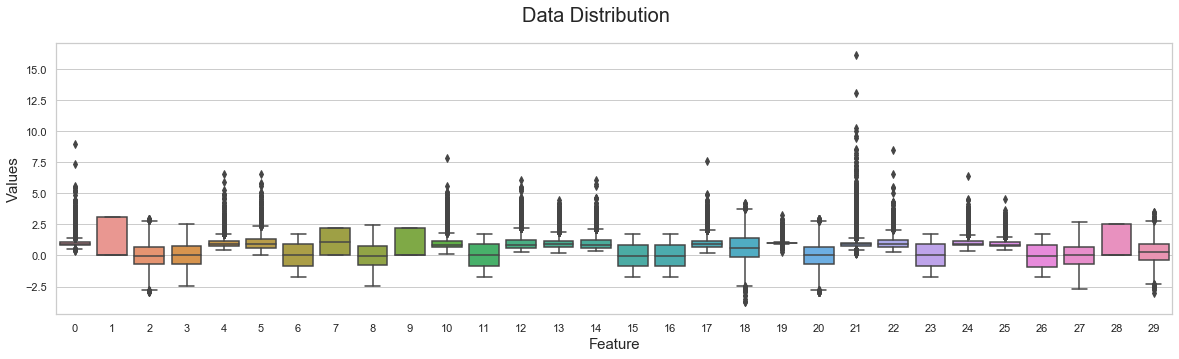

In [9]:
plt.figure(figsize=(20,5))
sns.set(style="whitegrid")
sns.boxplot(data=df_x)
plt.suptitle('Data Distribution', fontsize=20)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Values', fontsize=15)

## Eliminating Outliyers

How wee can see in the above figure there are many outliers, so to avoid this problem I will use the z-score to determine the data that lie between the 99% of the data. It is mean, I will eliminate the points that are far away of mean by 3 standard deviations [3].

(9548,)


Text(0, 0.5, 'Values')

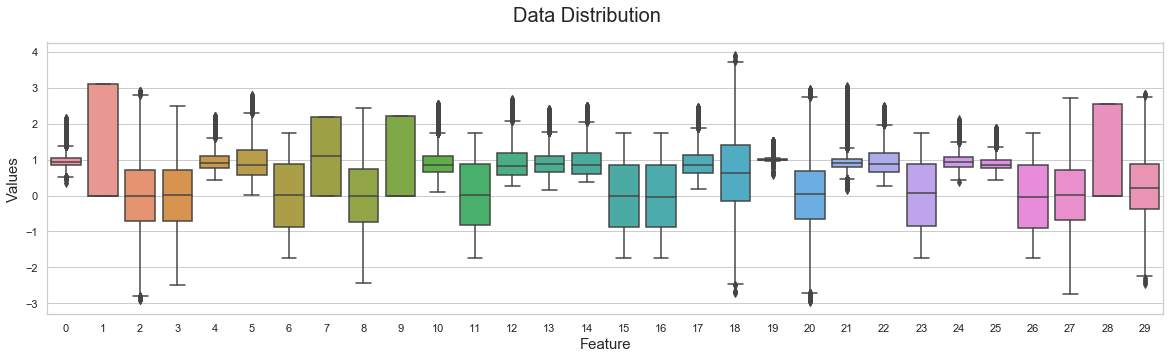

In [10]:
# X training and X validation
df_x_temp = df_x[(np.abs(stats.zscore(df_x)) < 3).all(axis=1)]
df_y_temp = df_y[(np.abs(stats.zscore(df_x)) < 3).all(axis=1)]
print(df_y_temp.shape)
plt.figure(figsize=(20,5))
sns.set(style="whitegrid")
sns.boxplot(data=df_x_temp)
plt.suptitle('Data Distribution', fontsize=20)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Values', fontsize=15)


In [11]:
print('{} outliyers were dropped'.format(np.abs(df_x.shape[0]-df_x_temp.shape[0])))

1452 outliyers were dropped


## Data Standardization 

There are two common types of scaling methods. One of them is **Normalization** typically means rescales the values into a range of [0,1].And another, is **Standardization** typically means rescales data to have a mean of 0 and a standard deviation of 1 (unit variance)[1]. I will choose the standardization method because is the most used in algorithms that using gradient descent updating [2]

In [12]:
df_x_stand = StandardScaler().fit_transform(df_x_temp)
df_x_test_stand = StandardScaler().fit_transform(df_x_test)


Text(0, 0.5, 'Values')

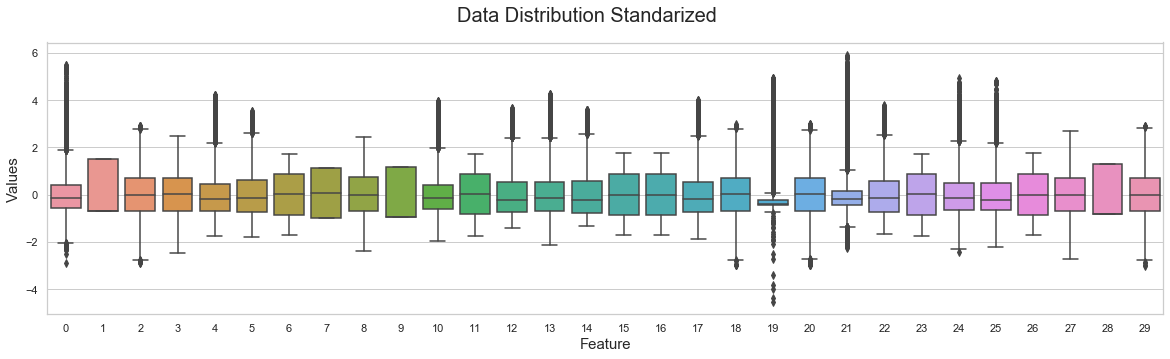

In [13]:
plt.figure(figsize=(20,5))
sns.set(style="whitegrid")
sns.boxplot(data=df_x_stand)
plt.suptitle('Data Distribution Standarized', fontsize=20)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Values', fontsize=15)

## Dimensionality Reduction

I will apply Principal Component Analysis (PCA) to reduce dimensionality of data, in consequence reduce memory management. Also i will retained 99% of varience [4].

shape of X_pca (9548, 30)
The number of components 26 correspond to 99 % variance of data retained:


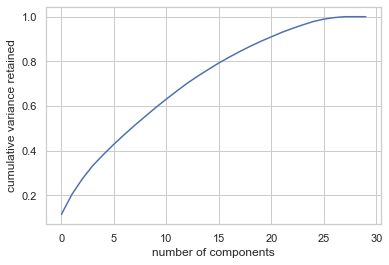

In [14]:
pca=PCA(n_components=30) # use all dimensions
pca.fit(df_x_stand) # obtener los componentes principales
X_pca=pca.transform(df_x_stand) # convertimos nuestros datos con las nuevas dimensiones de PCA
 
print("shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
print('The number of components {} correspond to 99 % variance of data retained:'.format(
    np.sum(np.cumsum(pca.explained_variance_ratio_)<0.99)))
#Vemos que con 27 componentes tenemos algo mas del 99% de varianza retenida
 
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative variance retained')
plt.show()

I choose to reduce to 26 dimensions.

Text(0, 0.5, 'Values')

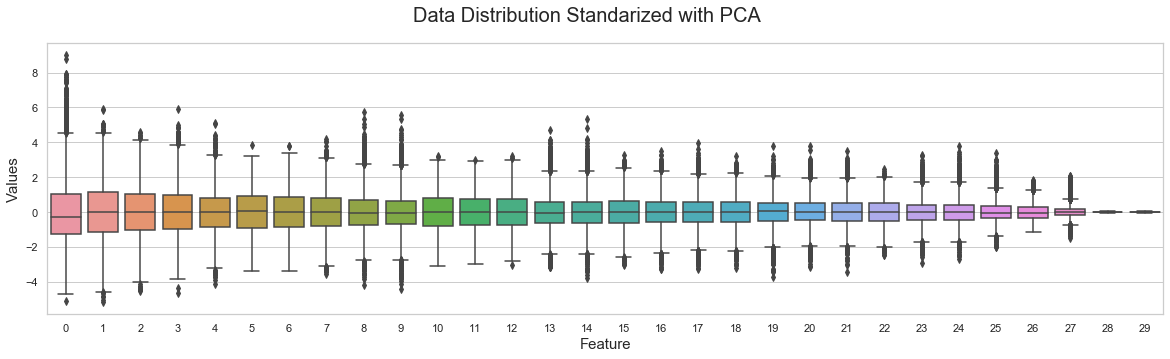

In [15]:
plt.figure(figsize=(20,5))
sns.set(style="whitegrid")
sns.boxplot(data=X_pca)
plt.suptitle('Data Distribution Standarized with PCA', fontsize=20)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Values', fontsize=15)

## Chossing Learning Rate

I will compare three distinct values of learning rate 0.1, 0.001, 0.0001

W0930 15:54:41.929750  5124 deprecation.py:323] From C:\Users\GABRIELA\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0930 15:54:42.349488  5124 deprecation_wrapper.py:119] From c:\users\gabriela\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



The  validation accuracy was 64.70961570739746 with Learning rate 0.01 
The  validation accuracy was 65.1856541633606 with Learning rate 0.001 
The  validation accuracy was 55.18882870674133 with Learning rate 0.0001 


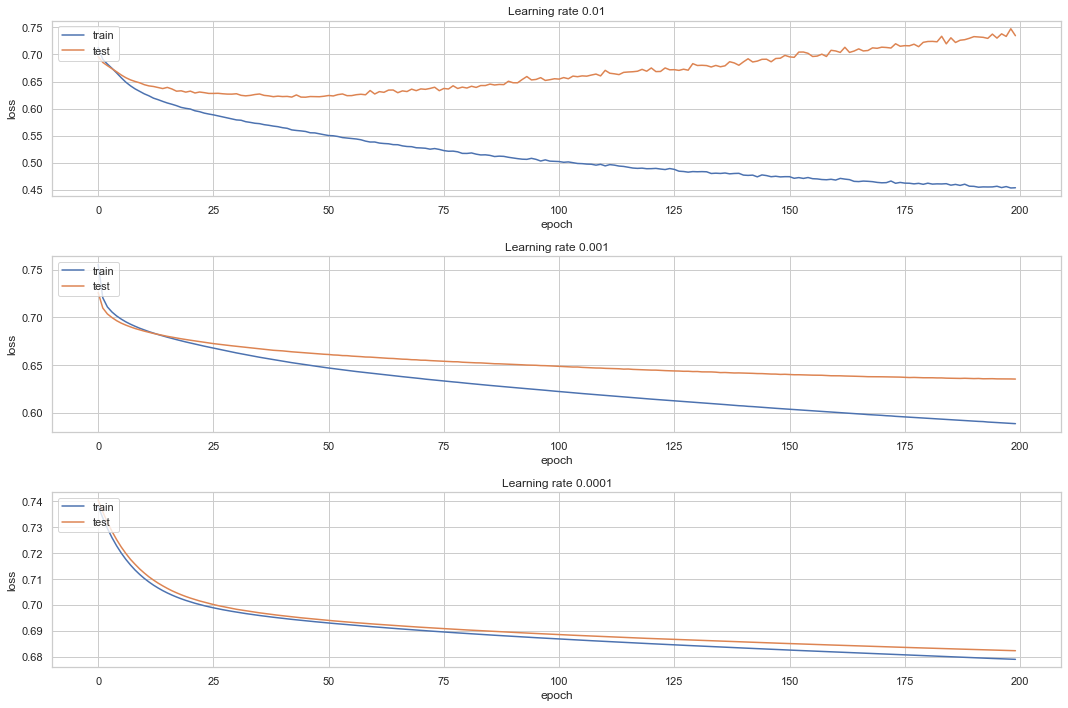

In [16]:
modelLR1 = Sequential()
modelLR1.add(Dense(20, input_dim=30, activation='relu'))
modelLR1.add(Dense(20, activation='relu'))
modelLR1.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.01, momentum=0.9)
# Compile model
modelLR1.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelLR1_Sco = modelLR1.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128, verbose = 0)

modelLR2 = Sequential()
modelLR2.add(Dense(20, input_dim=30, activation='relu'))
modelLR2.add(Dense(20, activation='relu'))
modelLR2.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.001, momentum=0.9)
# Compile model
modelLR2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelLR2_Sco = modelLR2.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128, verbose = 0)

modelLR3 = Sequential()
modelLR3.add(Dense(20, input_dim=30, activation='relu'))
modelLR3.add(Dense(20, activation='relu'))
modelLR3.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.0001, momentum=0.9)
# Compile model
modelLR3.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelLR3_Sco = modelLR3.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128, verbose = 0)

print('The  validation accuracy was {} with Learning rate 0.01 '.format(modelLR1_Sco.history['val_accuracy'][-1] * 100))
print('The  validation accuracy was {} with Learning rate 0.001 '.format(modelLR2_Sco.history['val_accuracy'][-1] * 100))
print('The  validation accuracy was {} with Learning rate 0.0001 '.format(modelLR3_Sco.history['val_accuracy'][-1] * 100))

plt.figure(figsize=(15,10))
    # summarize history for loss
plt.subplot(3,1,1)
plt.plot(modelLR1_Sco.history['loss'])
plt.plot(modelLR1_Sco.history['val_loss'])
plt.title('Learning rate 0.01')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    
        # summarize history for loss
plt.subplot(3,1,2)
plt.plot(modelLR2_Sco.history['loss'])
plt.plot(modelLR2_Sco.history['val_loss'])
plt.title('Learning rate 0.001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    
        # summarize history for loss
plt.subplot(3,1,3)
plt.plot(modelLR3_Sco.history['loss'])
plt.plot(modelLR3_Sco.history['val_loss'])
plt.title('Learning rate 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

## Chossing Activation Function

I will compare two distinct activation function saw in class: Sigmoid and Relu funtioncs

The  validation accuracy was 56.36305809020996 with sigmoid function 
The  validation accuracy was 64.1066312789917 with relu function 
The  validation accuracy was 66.35988354682922 with elu function 


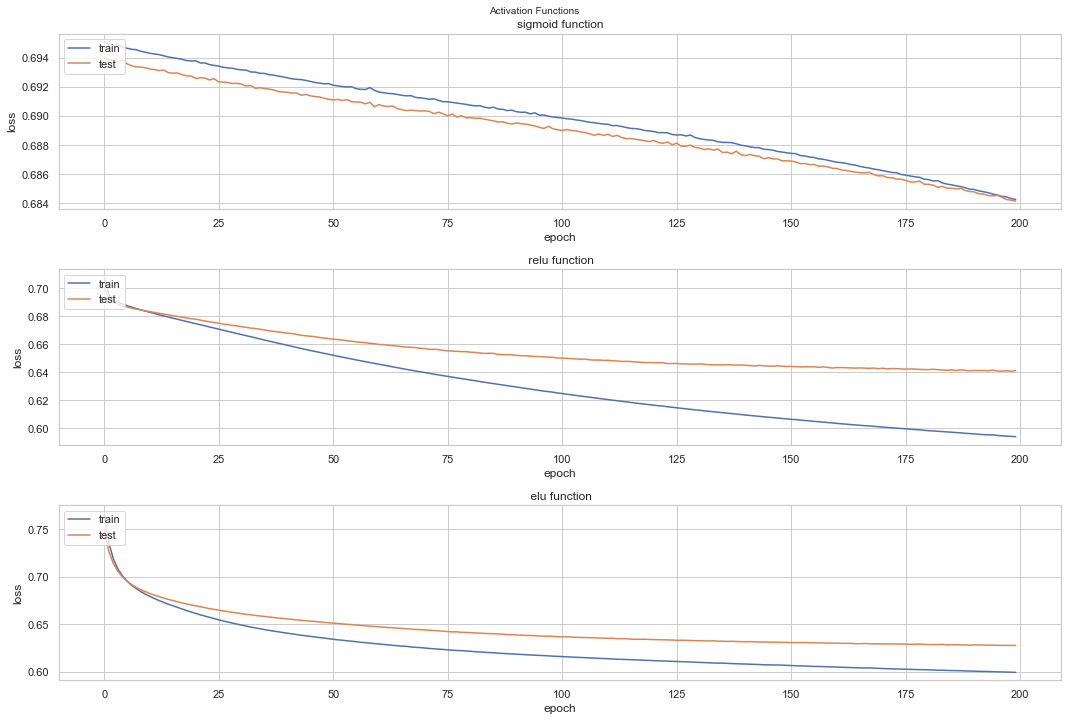

In [36]:
modelAF1 = Sequential()
modelAF1.add(Dense(20, input_dim=30, activation='sigmoid'))
modelAF1.add(Dense(20, activation='sigmoid'))
modelAF1.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.001, momentum=0.9)
# Compile model
modelAF1.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelAF1_Sco = modelAF1.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128,verbose = 0)

modelAF2 = Sequential()
modelAF2.add(Dense(20, input_dim=30, activation='relu'))
modelAF2.add(Dense(20, activation='relu'))
modelAF2.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.001, momentum=0.9)
# Compile model
modelAF2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelAF2_Sco = modelAF2.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128,verbose = 0)

modelAF3 = Sequential()
modelAF3.add(Dense(20, input_dim=30, activation='elu'))
modelAF3.add(Dense(20, activation='elu'))
modelAF3.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.001, momentum=0.9)
# Compile model
modelAF3.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelAF3_Sco = modelAF3.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128,verbose = 0)

print('The  validation accuracy was {} with sigmoid function '.format(modelAF1_Sco.history['val_accuracy'][-1] * 100))
print('The  validation accuracy was {} with relu function '.format(modelAF2_Sco.history['val_accuracy'][-1] * 100))
print('The  validation accuracy was {} with elu function '.format(modelAF3_Sco.history['val_accuracy'][-1] * 100))

plt.figure(figsize=(15,10))
plt.suptitle('Activation Functions', x = 0.5, y= 1, fontsize=10)
    # summarize history for loss
plt.subplot(3,1,1)
plt.plot(modelAF1_Sco.history['loss'])
plt.plot(modelAF1_Sco.history['val_loss'])
plt.title('sigmoid function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    
        # summarize history for loss
plt.subplot(3,1,2)
plt.plot(modelAF2_Sco.history['loss'])
plt.plot(modelAF2_Sco.history['val_loss'])
plt.title(' relu function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(3,1,3)
plt.plot(modelAF3_Sco.history['loss'])
plt.plot(modelAF3_Sco.history['val_loss'])
plt.title(' elu function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

How we can see above, elu function works better than the other two because de loss obtained is least.  Sigmoid diverges a lot and elu function appears work fine but takes a lot of epochs to minimize and start to diverge when relu function does as well.

## Explaining ELU actvation Function

Exponential Linear Unit is known as ELU. It is a function that tend to converge the loss to zero quicker therefore produce more accurate results. ELU has a extra alpha constant which should be positive number.

ELU seems to RELU except it works better with negative inputs because it doesn't suffer of dying activation like as RELU function does. They are both in identity function form for non-negative inputs. On the other hand, ELU becomes smooth slowly until its output equal to -α whereas RELU sharply smoothes.

![1mg2](./ELU.jpg)

Like the gradient ELU shows, it can produce negative values [6].

## Regularization Method

The training models have a overfitting overall when the loss is closer to 0.66, so I decided to apply some regularization techniques in order to avoid this problem. I will try with L1, L2 and dropout techniques to minimize the overfitting.

The  validation accuracy was 58.45763087272644 with L1 regularization
The  validation accuracy was 60.36179065704346 with L2 regularization
The  validation accuracy was 59.37797427177429 with Dropout regularization


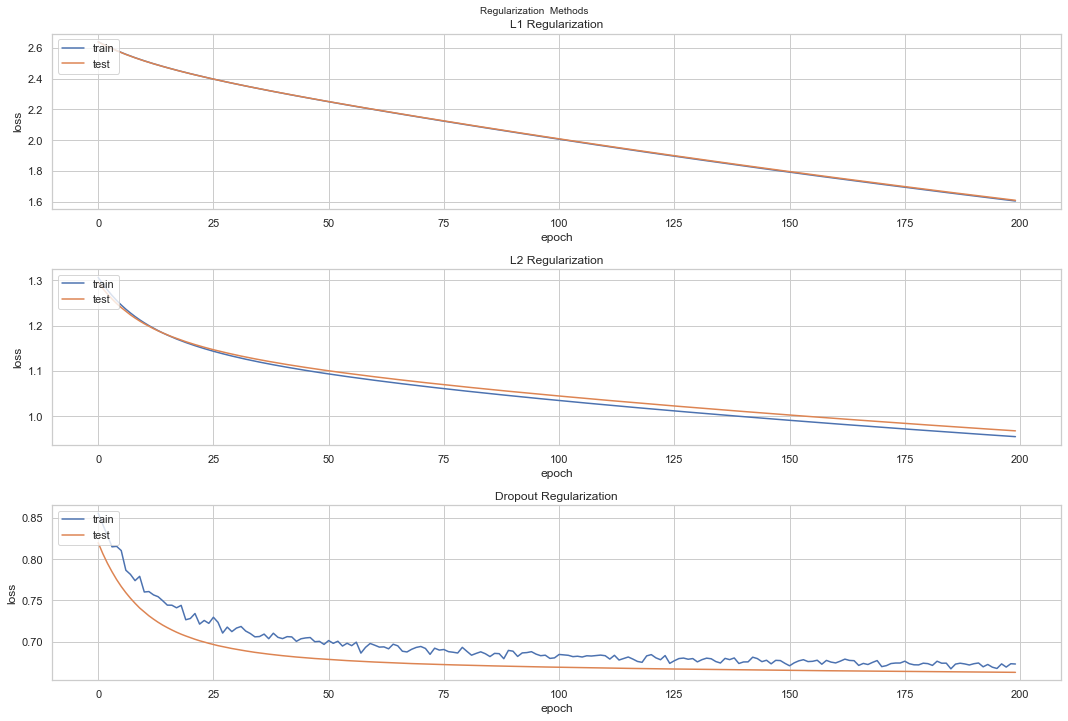

In [44]:
modelRg1 = Sequential()
modelRg1.add(Dense(20, input_dim=30, activation='elu',kernel_regularizer=l1(l=0.01)))
modelRg1.add(Dense(20, activation='elu',kernel_regularizer=l1(l=0.01)))
modelRg1.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.0001, momentum=0.9)
# Compile model
modelRg1.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelRg1_Sco = modelRg1.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128,verbose = 0)

modelRg2 = Sequential()
modelRg2.add(Dense(20, input_dim=30, activation='elu',kernel_regularizer=l2(l=0.01)))
modelRg2.add(Dense(20, activation='elu',kernel_regularizer=l2(l=0.01)))
modelRg2.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.0001, momentum=0.9)
# Compile model
modelRg2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelRg2_Sco = modelRg2.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128,verbose = 0)

modelRg3 = Sequential()
modelRg3.add(Dense(20, input_dim=30, activation='elu'))
modelRg3.add(Dropout(0.2))
modelRg3.add(Dense(20, activation='elu'))
modelRg3.add(Dropout(0.2))
modelRg3.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.0001, momentum=0.9)
# Compile model
modelRg3.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelRg3_Sco = modelRg3.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128,verbose = 0)

print('The  validation accuracy was {} with L1 regularization'.format(modelRg1_Sco.history['val_accuracy'][-1] * 100))
print('The  validation accuracy was {} with L2 regularization'.format(modelRg2_Sco.history['val_accuracy'][-1] * 100))
print('The  validation accuracy was {} with Dropout regularization'.format(modelRg3_Sco.history['val_accuracy'][-1] * 100))

plt.figure(figsize=(15,10))
plt.suptitle('Regularization  Methods', x = 0.5, y= 1, fontsize=10)
    # summarize history for loss
plt.subplot(3,1,1)
plt.plot(modelRg1_Sco.history['loss'])
plt.plot(modelRg1_Sco.history['val_loss'])
plt.title('L1 Regularization')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    
        # summarize history for loss
plt.subplot(3,1,2)
plt.plot(modelRg2_Sco.history['loss'])
plt.plot(modelRg2_Sco.history['val_loss'])
plt.title('L2 Regularization')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(3,1,3)
plt.plot(modelRg3_Sco.history['loss'])
plt.plot(modelRg3_Sco.history['val_loss'])
plt.title('Dropout Regularization')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

How we can see the above figure, regularization technique that works better is the L2. So, in the next stage I will choose a lambda value to get better accuracy validation outcome.

## Explaining Dropout Technique

Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.  In setting the output to 0, the cost function becomes more sensitive to neighbouring neurons changing the way the weights will be updated during the process of backpropagation. To make some hidden units output to zero, the dropout follows a distribution of Bernoulli Bimodal to determine which hidden unit in nth layer becomes zero output.

![img3](./Dropout.JPG)

Where r(i) becomes 0 or 1 by the Bernoulli distribution and the unit becomes inactivated or activated by element-wise product with r(i) [5].

## Choosing Lambda Value to L2 regularization tecnique

The  validation accuracy was 57.2199285030365 with 0.01 Lambda regularization
The  validation accuracy was 59.85401272773743 with 0.05 Lambda regularization
The  validation accuracy was 59.85401272773743 with 0.005 Lambda regularization


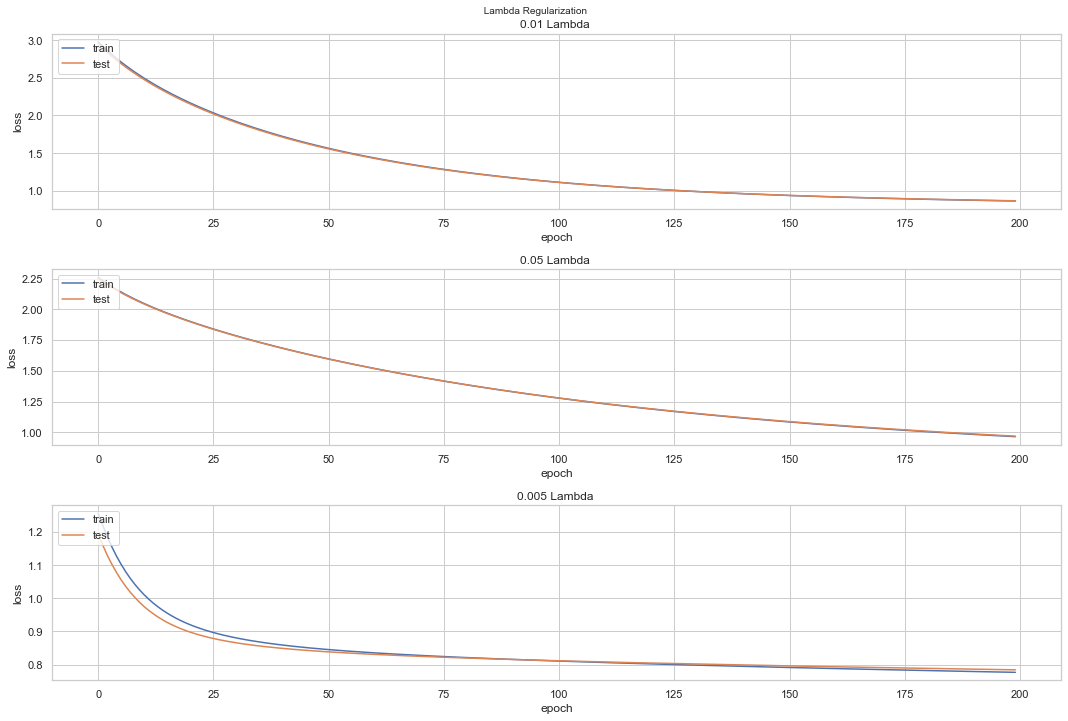

In [56]:
modelL2_1 = Sequential()
modelL2_1.add(Dense(20, input_dim=30, activation='elu',kernel_regularizer=l2(l=0.01)))
modelL2_1.add(Dense(20, activation='elu',kernel_regularizer=l2(l=0.1)))
modelL2_1.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.0001, momentum=0.9)
# Compile model
modelL2_1.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelL2_1_Sco = modelL2_1.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128,verbose = 0)

modelL2_2 = Sequential()
modelL2_2.add(Dense(20, input_dim=30, activation='elu',kernel_regularizer=l2(l=0.05)))
modelL2_2.add(Dense(20, activation='elu',kernel_regularizer=l2(l=0.01)))
modelL2_2.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.0001, momentum=0.9)
# Compile model
modelL2_2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelL2_2_Sco = modelL2_2.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128,verbose = 0)

modelL2_3 = Sequential()
modelL2_3.add(Dense(20, input_dim=30, activation='elu',kernel_regularizer=l2(l=0.005)))
modelL2_3.add(Dense(20, activation='elu',kernel_regularizer=l2(l=0.001)))
modelL2_3.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.0001, momentum=0.9)
# Compile model
modelL2_3.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
modelL2_3_Sco = modelL2_3.fit(df_x_stand,df_y_temp, validation_split=0.33, epochs=200, batch_size=128,verbose = 0)

print('The  validation accuracy was {} with 0.01 Lambda regularization'.format(modelL2_1_Sco.history['val_accuracy'][-1] * 100))
print('The  validation accuracy was {} with 0.05 Lambda regularization'.format(modelL2_2_Sco.history['val_accuracy'][-1] * 100))
print('The  validation accuracy was {} with 0.005 Lambda regularization'.format(modelL2_3_Sco.history['val_accuracy'][-1] * 100))

plt.figure(figsize=(15,10))
plt.suptitle(' Lambda Regularization', x = 0.5, y= 1, fontsize=10)
    # summarize history for loss
plt.subplot(3,1,1)
plt.plot(modelL2_1_Sco.history['loss'])
plt.plot(modelL2_1_Sco.history['val_loss'])
plt.title('0.01 Lambda ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
    
        # summarize history for loss
plt.subplot(3,1,2)
plt.plot(modelL2_2_Sco.history['loss'])
plt.plot(modelL2_2_Sco.history['val_loss'])
plt.title('0.05 Lambda ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(3,1,3)
plt.plot(modelL2_3_Sco.history['loss'])
plt.plot(modelL2_3_Sco.history['val_loss'])
plt.title('0.005 Lambda ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [69]:
print('error in validation accuracy against use not regularization',
      ((66.35988354682922 - 59.85401272773743)/66.35988354682922) *100)

error in validation accuracy against use not regularization 9.80392139250922


How we can see the above figure, regularization model with a lambda that shows better results is the value 0.005 because the loss descent smoothly and get least values. However the validation accuracy is less in 9.8% that use not regularization techniques.

## Creating Model

Before to try many different setting with distinct hyperparameters settings I will choose a learning rate of 0.001 because when I worked with 0.01 the models suffered "catastrophic forgetting" and the loss between training and validation set diverge. With learning rate of 0.0001 the model take a lot of time to converge and its average loss doesn't descend quiclky.  

On the other hand, I proved that use eLu activation over sigmoid and Relu activation function appears to get a better result. That could due to the sigmoid activation suffer a lot of saturation on input values higher than |3| so the updating gradient descent doesn't work. On the other hand, relu has a problem called "Dying relu" which consist of some inactivation units. That happens because the gradient of relu makes all imput values below zero resulting in zero. 

On the other hand, I will no regularize the model by using L1 or L2 saw in class as well not dropout method proposed by Goeffry Hinton in [5] because I obtained better accuracy without using that.

In [63]:
#create model
model1 = Sequential()
model1.add(Dense(10, input_dim=26, activation='elu'))
model1.add(Dense(10, activation='elu'))
model1.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.001, momentum=0.9)
# Compile model
model1.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
#model1.fit(X_pca_train,df_y_temp, validation_split=0.33, epochs=150, batch_size=10)
print(model1.summary())

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_225 (Dense)            (None, 10)                270       
_________________________________________________________________
dense_226 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_227 (Dense)            (None, 1)                 11        
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
#create model
model2 = Sequential()
model2.add(Dense(20, input_dim=26, activation='elu'))
model2.add(Dense(20, activation='elu'))
model2.add(Dense(1, activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.001, momentum=0.9)
model2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
#model1.fit(X_pca_train,df_y_temp, validation_split=0.33, epochs=150, batch_size=10)
print(model2.summary())

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_228 (Dense)            (None, 20)                540       
_________________________________________________________________
dense_229 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_230 (Dense)            (None, 1)                 21        
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________
None


In [65]:
#create model
model3 = Sequential()
model3.add(Dense(10, input_dim=26, activation='elu'))
model3.add(Dense(10, activation='elu'))
model3.add(Dense(10, activation='elu'))
model3.add(Dense(10, activation='elu'))
model3.add(Dense(1, activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.001, momentum=0.9)
model3.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
#model1.fit(X_pca_train,df_y_temp, validation_split=0.33, epochs=150, batch_size=10)
print(model3.summary())

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_231 (Dense)            (None, 10)                270       
_________________________________________________________________
dense_232 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_233 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_234 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_235 (Dense)            (None, 1)                 11        
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
#create model
model4 = Sequential()
model4.add(Dense(20, input_dim=26, activation='elu'))
model4.add(Dense(20, activation='elu'))
model4.add(Dense(20, activation='elu'))
model4.add(Dense(1, activation='sigmoid'))
# Compile model
sgd = SGD(lr=0.001, momentum=0.9)
model4.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model4.summary())

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_240 (Dense)            (None, 20)                540       
_________________________________________________________________
dense_241 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_242 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_243 (Dense)            (None, 1)                 21        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________
None


## Cross Validation

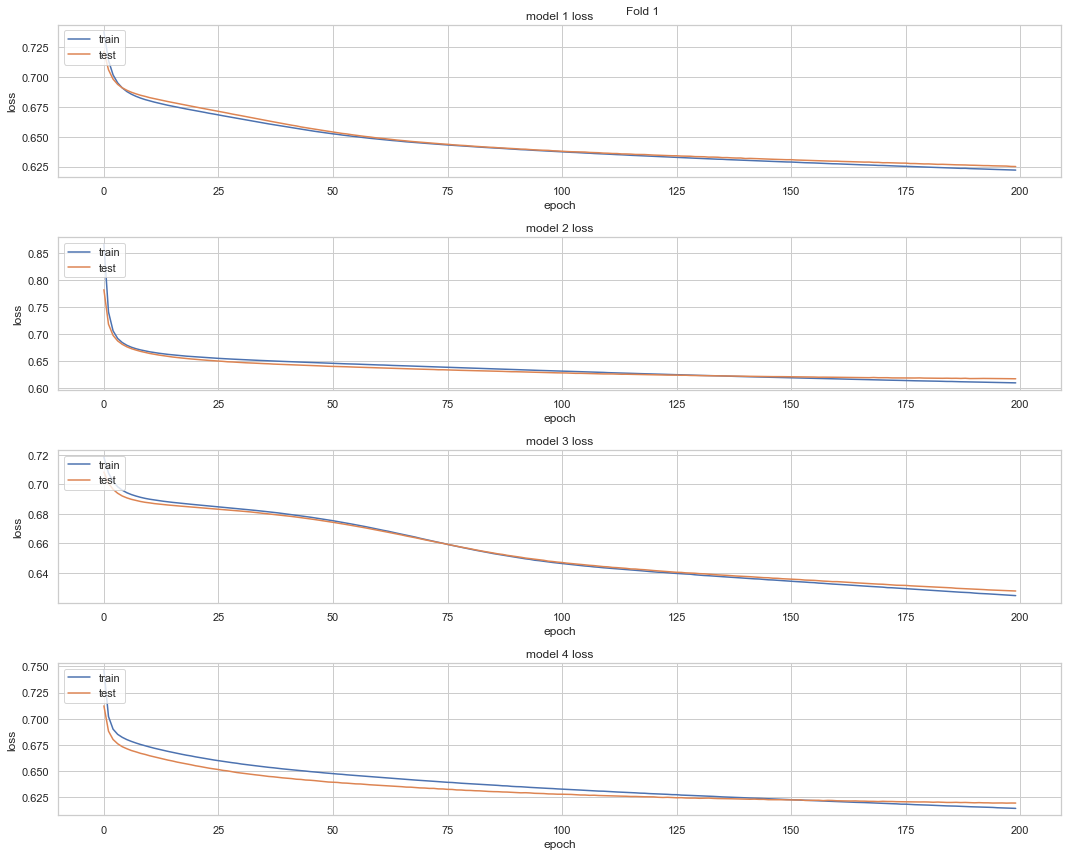

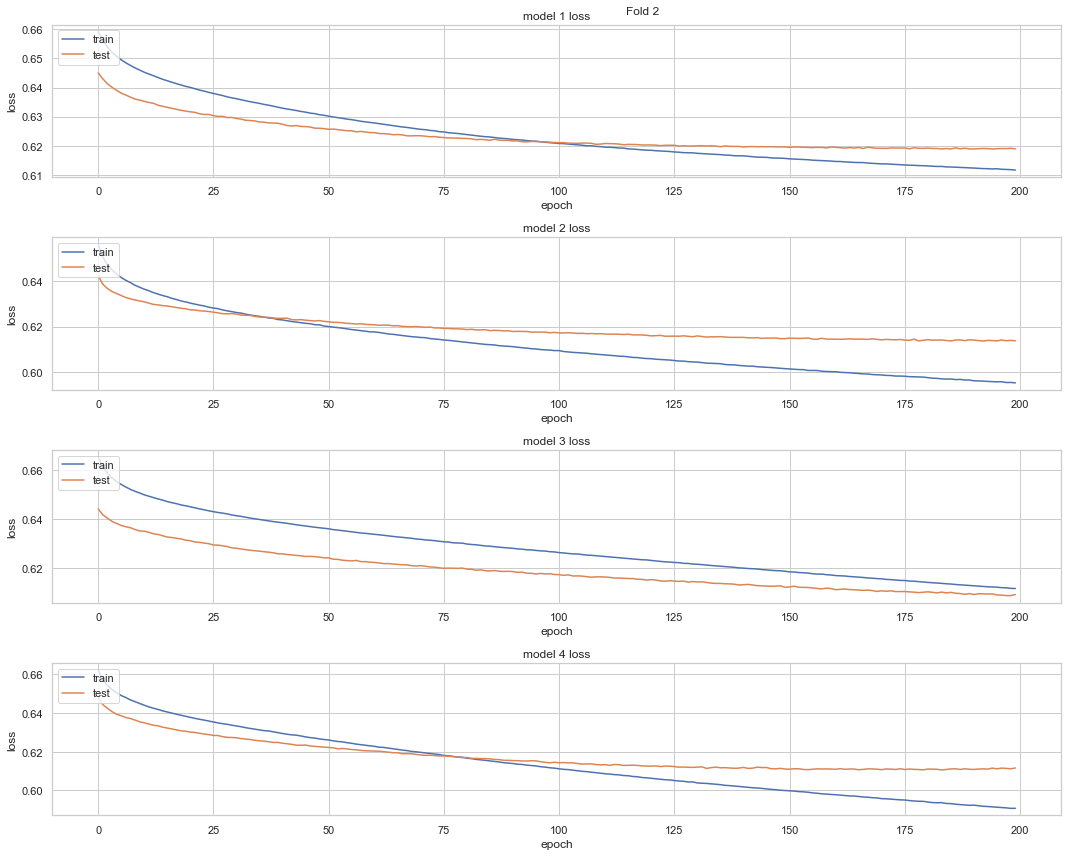

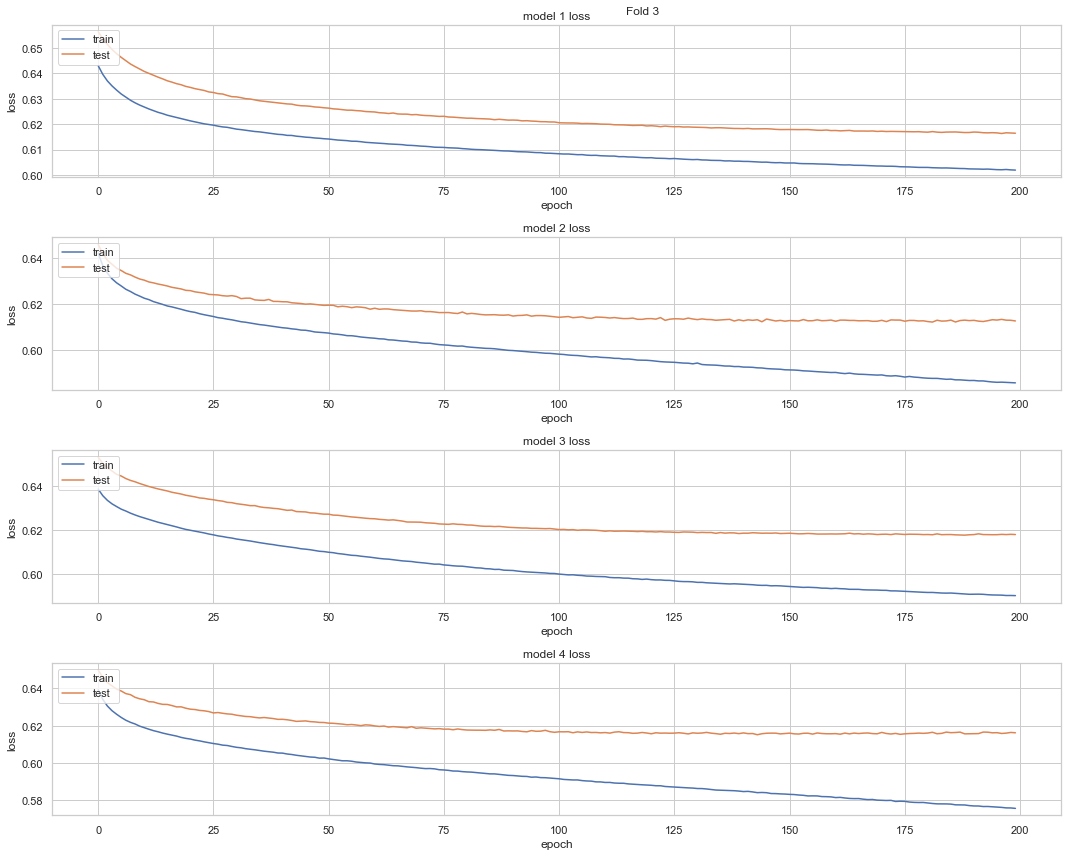

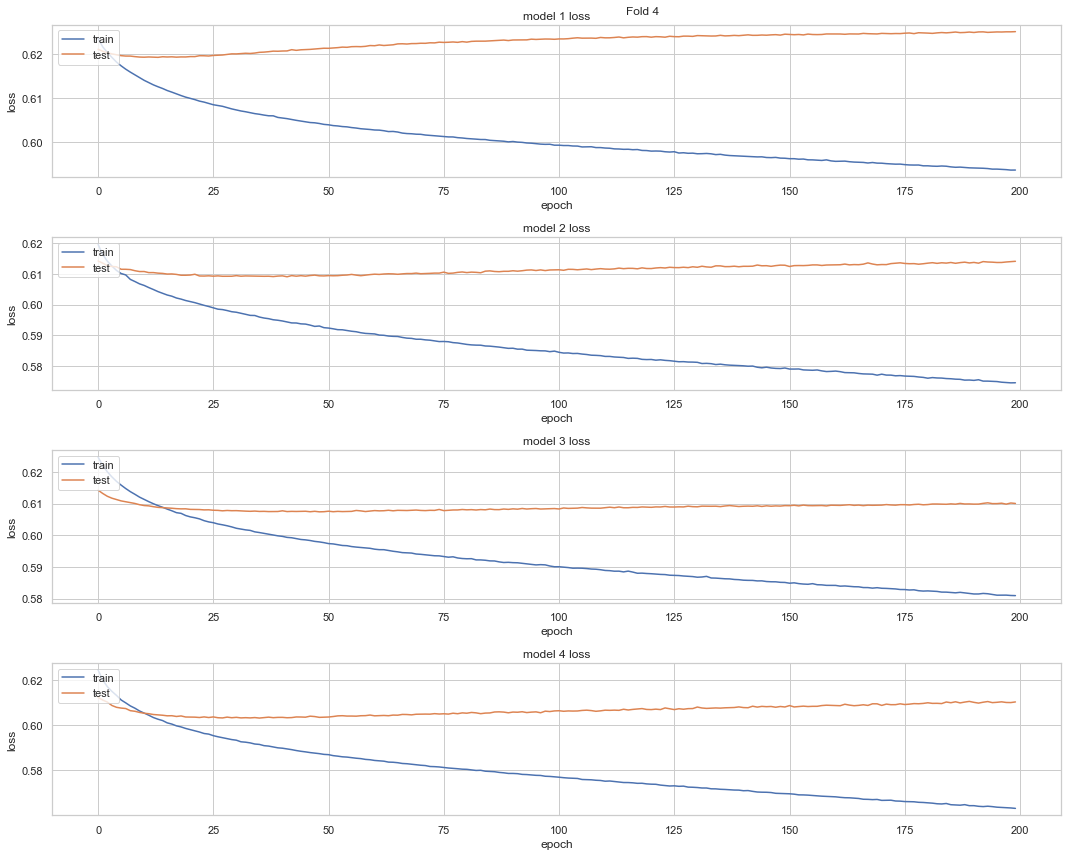

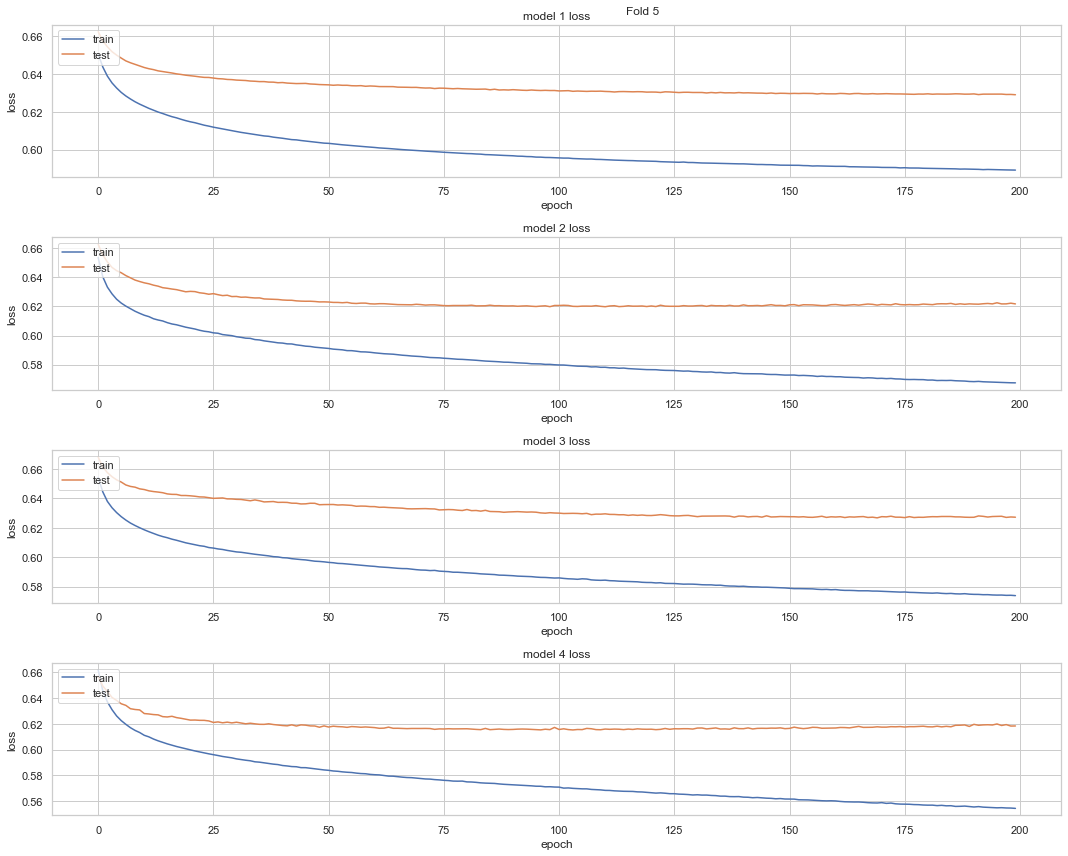

65.40% (+/- 0.92%)
66.31% (+/- 1.08%)
65.49% (+/- 1.16%)
66.63% (+/- 0.98%)


In [68]:
kfold = KFold(n_splits=5, shuffle=True, random_state=7)
cvscores1 = []
cvscores2 = []
cvscores3 = []
cvscores4 = []
figure = 1
pca=PCA(n_components=26) # use 26 dimensions
for train, test in kfold.split(df_x_stand, df_y_temp):
    #apply PCA
    # X train 
    pca.fit(df_x_stand[train]) # obtener los componentes principales
    X_pca_train=pca.transform(df_x_stand[train]) # convertimos nuestros datos con las nuevas dimensiones de PCA
    # X validation
    X_pca_valid=pca.transform(df_x_stand[test])
    
    
    # Fit the model1
    scores1 = model1.fit(X_pca_train, df_y_temp[train],validation_data=(X_pca_valid,df_y_temp[test]), epochs=200, batch_size=128, verbose=0)
    #print(scores1.history.keys())
    cvscores1.append(scores1.history['val_accuracy'][-1] * 100)
    
    # Fit the model2
    scores2 =model2.fit(X_pca_train, df_y_temp[train],validation_data=(X_pca_valid,df_y_temp[test]), epochs=200, batch_size=128, verbose=0)
    cvscores2.append(scores2.history['val_accuracy'][-1] * 100)
    
    # Fit the model3
    scores3 = model3.fit(X_pca_train, df_y_temp[train],validation_data=(X_pca_valid,df_y_temp[test]), epochs=200, batch_size=128, verbose=0)
    cvscores3.append(scores3.history['val_accuracy'][-1] * 100)
    
    # Fit the model4
    scores4 =model4.fit(X_pca_train, df_y_temp[train],validation_data=(X_pca_valid,df_y_temp[test]), epochs=200, batch_size=128, verbose=0)
    cvscores4.append(scores4.history['val_accuracy'][-1] * 100)
    
    plt.figure(figsize=(15,12))
    plt.suptitle('Fold '+str(figure), x = 0.6, y= 0.99, fontsize=12)
    # summarize history for loss
    plt.subplot(4,1,1)
    plt.plot(scores1.history['loss'])
    plt.plot(scores1.history['val_loss'])
    plt.title('model 1 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
        # summarize history for loss
    plt.subplot(4,1,2)
    plt.plot(scores2.history['loss'])
    plt.plot(scores2.history['val_loss'])
    plt.title('model 2 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
        # summarize history for loss
    plt.subplot(4,1,3)
    plt.plot(scores3.history['loss'])
    plt.plot(scores3.history['val_loss'])
    plt.title('model 3 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
        # summarize history for loss
    plt.subplot(4,1,4)
    plt.plot(scores4.history['loss'])
    plt.plot(scores4.history['val_loss'])
    plt.title('model 4 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')  
    plt.tight_layout()
    plt.show()
    
    figure +=1
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores1), np.std(cvscores1)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores2), np.std(cvscores2)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores3), np.std(cvscores3)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores4), np.std(cvscores4)))

The above outcomes shows that the better validation accuracy was obtainerd by the 4 model arquitecture. It is composed of three dense layers of 20 units each one. 

## References :
[1] S. Geller, “Normalization vs Standardization - Quantitative analysis,” Medium, 05-Apr-2019. [Online]. Available: https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf. [Accessed: 29-Sep-2019].

[2] S. Raschka, “About Feature Scaling and Normalization,” Dr. Sebastian Raschka, 11-Jul-2014. [Online]. Available: https://sebastianraschka.com/Articles/2014_about_feature_scaling.html. [Accessed: 29-Sep-2019].

[3] “Removing Outliers Using Standard Deviation in Python,” KDnuggets. [Online]. Available: https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html. [Accessed: 30-Sep-2019].

[4] A. Ng, “PCA,” Coursera. [Online]. Available: https://www.coursera.org/learn/machine-learning/home/welcome. [Accessed: 30-Sep-2019].

[5] Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958.

[6] Clevert, D. A., Unterthiner, T., & Hochreiter, S. (2015). Fast and accurate deep network learning by exponential linear units (elus). arXiv preprint arXiv:1511.07289.